In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from collections import Counter
import squidpy as sq
from scipy.spatial.distance import pdist, squareform
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import tabulate
from scipy.stats.stats import pearsonr 
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn import metrics
from scipy.spatial.distance import pdist, squareform
import itertools
import networkx as nx
from scipy.sparse import csgraph
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import umap
from importlib import reload
from matplotlib import rc
from scipy import stats

rc('text', usetex=True)

# locals
import utils as ut
reload(ut)

sc.settings.verbosity = 3
import gget

# locals
import utils as ut
reload(ut)

2022-12-06 11:45:43.724942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 11:45:43.858122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-12-06 11:45:43.858146: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-06 11:45:43.883917: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-06 11:45:45.3301

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
# load gene lists 
pandPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"        
pandf = ut.read_panglaodb(pandPath)

controlList = [
    'Adipocytes',
    'B cells', 
    'Dendritic cells',
    'Macrophages',
    'Monocytes', 
    'NK cells',
    'T cells', 
]

allMarkers = pandf[pandf['cell type'].isin(controlList)]
"""
Ubiquitousness Index (0-1). 
0 indicates the gene is not expressed in any cell cluster and 
1 (maximum) indicates that the gene is expressed in all cell clusters. 
"""

mfList = []

for ctype in controlList:
    cf = allMarkers[allMarkers['cell type'] == ctype]
    
    cf = cf.sort_values(by='ubiquitousness index',
                        ascending=True)
    
    mfList.append(cf[['cell type', 'gene']])


markerGenes = pd.concat(mfList, ignore_index=True)
# take only markers for a specific cell type
markerGenes['cellTypeCount'] = markerGenes.groupby('gene')['cell type'].transform('nunique')
markerGenes = markerGenes[markerGenes['cellTypeCount'] < 2]
markerGenes['cell type'].value_counts()

Adipocytes         110
B cells             85
Macrophages         85
Dendritic cells     72
T cells             67
NK cells            57
Monocytes           56
Name: cell type, dtype: int64

In [3]:
fPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/LR/LewisLabUSCS/Mouse/Mouse-2020-Baccin-LR-pairs.xlsx"

lr = pd.read_excel(fPath)
print(lr.shape)

lr['ligand'] = lr['Ligand.Mouse'].str.upper()
lr['receptor'] = lr['Receptor.Mouse'].str.upper()
lr.head()

(2000, 8)


,Pair.Name,Ligand.Mouse,Receptor.Mouse,Source,ManualAnnotation,Ligand.CC,Ligand.GO,Reference (PMID / KEGG),ligand,receptor
0,A2m-Lrp1,A2m,Lrp1,Ramilowski,Correct,Secreted,Other,"1702392,10652313, 12194978",A2M,LRP1
1,Adgre5-Cd55,Adgre5,Cd55,Baccin,Correct,Membrane,Other,23447688,ADGRE5,CD55
2,Adipoq-Adipor1,Adipoq,Adipor1,Ramilowski,Correct,Secreted,Other,12802337,ADIPOQ,ADIPOR1
3,Adipoq-Adipor2,Adipoq,Adipor2,Ramilowski,Correct,Secreted,Other,"12802337, 12802330",ADIPOQ,ADIPOR2
4,Adm-Calcrl&Ramp2,Adm,Calcrl&Ramp2,Baccin,Correct,Secreted,Other,10342881,ADM,CALCRL&RAMP2


In [4]:
clusterPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/clusters.csv"
cf = pd.read_parquet(clusterPath)
print(cf.shape)
print(cf['cellType'].unique())
cf.head()

(427882, 7)
['Macrophages' 'B cells' 'Monocytes' 'NK cells' 'Dendritic cells'
 'T cells' 'Stromal cells']


,gene,scores,pvals,logfoldchanges,clusterId,key,cellType
0,H2-EB1,36.343353,4.575346e-181,3.564091,1,ND,Macrophages
1,H2-AA,35.311523,4.761517e-183,3.430534,1,ND,Macrophages
2,H2-AB1,34.411163,2.815112e-177,3.234597,1,ND,Macrophages
3,CD74,33.910587,2.451588e-177,3.302062,1,ND,Macrophages
4,H2-DMA,31.695400,2.991793e-123,2.667091,1,ND,Macrophages


In [5]:
"""load scRNA"""
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/"

rna = {}

for f in os.listdir(dirPath):
    
    if f.endswith('.h5ad'):
        key = f.split(".")[0]
        fullPath = f"{dirPath}{f}"
        data = sc.read(fullPath)
        rna[key] = data
    
print("done")

done


In [6]:
"""Load spatial """
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/"

spt = {}

for f in os.listdir(dirPath):
    
    if not f == "all":
        key = f
        mtxPath = f"{dirPath}{f}/outs/"
        data = sc.read_visium(mtxPath)
        data.var_names_make_unique()
        data.var_names = [x.upper() for x in data.var_names]
        spt[key] = data
    
keys = ['HFD14']

min_counts = 10

for key in keys:
    print(key)
    data = spt[key]
    sc.pp.filter_cells(data, min_counts=min_counts)
    sc.pp.normalize_total(data, target_sum=1e4) # Normalize each cell by total counts over all genes
    sc.pp.log1p(data) # Logarithmize data via `X = \log(X + 1)`,
    sc.pp.scale(data) # unit variance and zero mean

print('done')

reading /nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/HFD14/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
reading /nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/ND/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
reading /nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/HFD8/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
HFD14
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
done


In [7]:
""" get markers genes """
lft = 1.5
alpha = 0.05
usePangloa = False
propCluster = 0.5

key = 'HFD8'
ctypes = ['Macrophages', 'Monocytes']

markers = {}

for ctype in ctypes:
    
    # use the curated list
    if usePangloa:
         # get the marker genes for each cell type
        mGenes = markerGenes[markerGenes['cell type'] == ctype]['gene'].to_list()
        markers[ctype] = mGenes
        
    # use detected genes
    else:
        mask = (cf['cellType'] == ctype) & (cf['key'] == key)
        cdf = cf[mask].reset_index(drop=True)
        
        cdf = cdf[cdf['logfoldchanges'] >= lft].reset_index(drop=True)
        cdf = cdf[cdf['pvals'] <= alpha].reset_index(drop=True)
        
        cdf['geneCount'] = cdf.groupby('gene')['clusterId'].transform('nunique')
        cdf['nCluster'] = cdf['clusterId'].nunique()
        
        mask = (cdf['geneCount'] >= (cdf['nCluster'] * propCluster))
        cdf = cdf[mask].reset_index(drop=True)
        
        mGenes = cdf['gene'].to_list()
        markers[ctype] = list(set(mGenes))
        
    print(f"{ctype} n markers {len(set(mGenes))} use panglao {usePangloa}")
        
print('done')

Macrophages n markers 76 use panglao False
Monocytes n markers 113 use panglao False
done


In [8]:
def sortMat(D, by='sum'):
        
    if by == 'sum':
        ind = np.argsort(D.sum(axis=0))[::-1]
    elif by == 'mean':
        ind = np.argsort(D.mean(axis=0))[::-1]
    elif by == 'min':
        ind = np.argsort(D.min(axis=0))[::-1]
    elif by == 'max':
        ind = np.argsort(D.max(axis=0))[::-1]
    elif by == 'std':
        ind = np.argsort(D.std(axis=0))[::-1]
    else:
        raise ValueError(f'Have not implemented: {by}')
        
    Dhat = D[ind, :][:, ind]
    return Dhat, ind

rf.shape=(6123, 13768)
HFD8 Macrophages n cells: 2188 m genes: 76
cells.shape=(2188, 76)
D.shape=(76, 76)


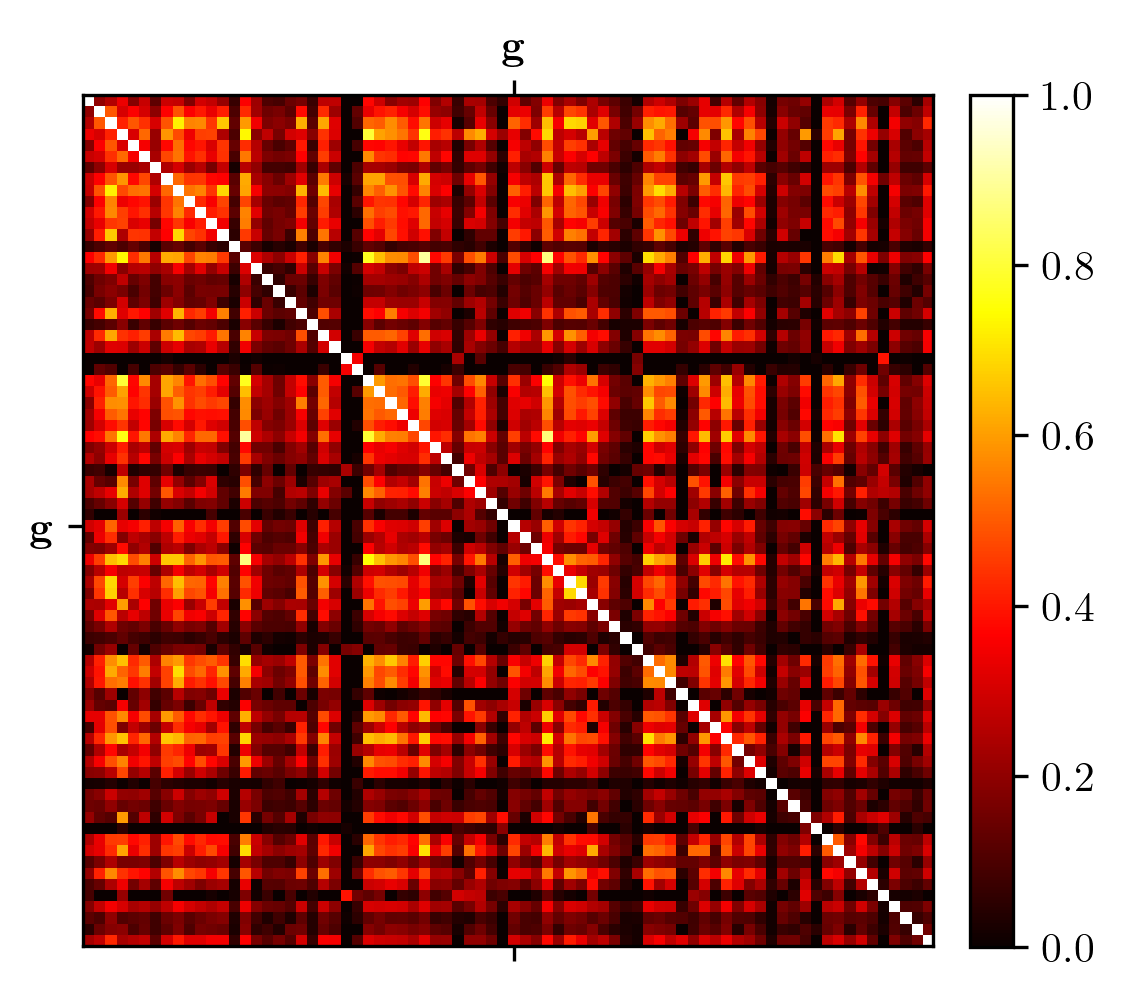

In [9]:
""" single gene-gene network """

metric = "correlation"
sort = False

ctypes = ['Macrophages']


clusterIds = {}

# get cell type specific indices
for ctype in ctypes: 
    mask = (cf['cellType'] == ctype) & (cf['key'] == key)
    t = cf[mask]['clusterId'].unique() 
    clusterIds[ctype] = t
    
    
""" get RNA data"""
data = rna[key]

rf = data.to_df()
print(f"{rf.shape=}")

# get the run key
allKeys = list(data.obs.keys() )
allKeys.remove('n_genes')
runKey = allKeys[0]

clusterInd = data.obs[runKey].astype(int) + 1   # note that these are zero-indexed!

# get the cells and genes from the scRNA seq data
allmarkers = list(np.concatenate([markers[x] for x in ctypes]).flat)
allInd = list(np.concatenate([clusterIds[x] for x in ctypes]).flat)
expressedMarkers = [x for x in allmarkers if x in rf.columns]
cellInd = clusterInd.isin(allInd)

# print the number of expressed genes
for i, ctype in enumerate(ctypes):
    cind = clusterIds[ctype]
    nCell = np.sum(clusterInd.isin(cind))
    nGene = len(markers[ctype])
    print(f"{key} {ctype} n cells: {nCell} m genes: {nGene}")
    # # get the last index of expressed genes for axvline drawing    
    if i == 0:
        lastInd = nGene

# subset the expression matrix based on marker genes
cells = rf[cellInd]
cells = cells[expressedMarkers]


cells = cells.fillna(0)
print(f"{cells.shape=}")
    
dists = pdist(cells.T, metric)
D = squareform(dists) 

D = 1 - D # since we computed 1-corr, we get corr back

# D, ind = sortMat(D)

print(f"{D.shape=}")
# D *= 1.0/D.max()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "w"
if sort:
    D = sortMat(D, by='min')
    print(f"{D.shape=}")
    
plt.matshow(D, vmin=0, vmax=1, cmap='hot')
plt.colorbar(fraction=0.0458, pad=0.04)

# l1 = (lastInd) / 2
# l2 = ((len(expressedMarkers) - lastInd) / 2 ) + lastInd

# _ = plt.xticks([l1, l2], [ctypes[0], ctypes[1]])
# plt.xlabel(r'$\mathbf{g}$')
# plt.ylabel(r'$\mathbf{g}$')
loc = D.shape[0] / 2
_ = plt.yticks([loc], [r'$\mathbf{g}$'])
_ = plt.xticks([loc], [r'$\mathbf{g}$'])
# plt.title(key)

In [10]:
# break

rf.shape=(6123, 13768)
HFD8 Macrophages n cells: 2188 m genes: 76
HFD8 Monocytes n cells: 714 m genes: 113
cells.shape=(2902, 189)
D.shape=(189, 189)


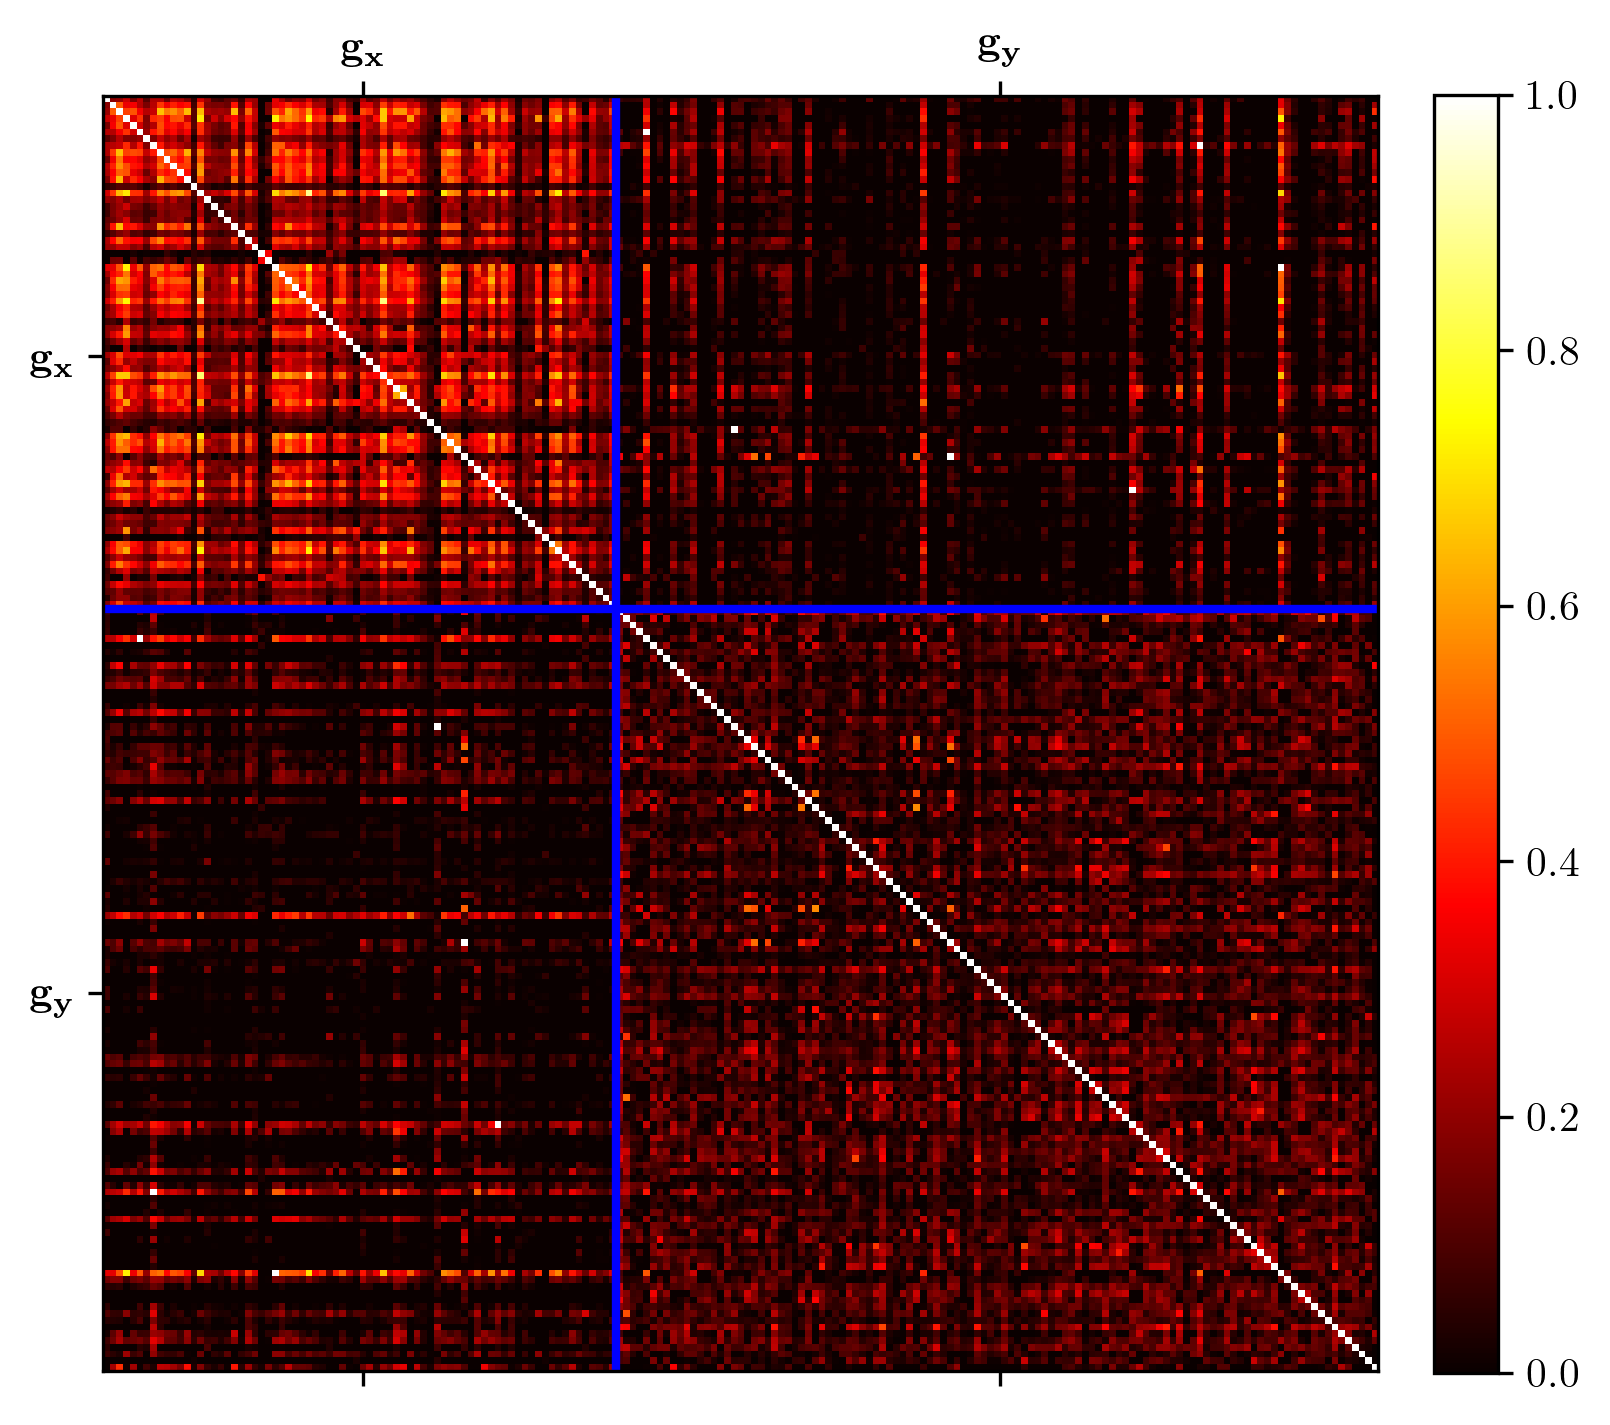

In [11]:
""" plot macrophage/monocyte graphs infividually """

ctypes = ['Macrophages', 'Monocytes']

metric = "correlation"
# metric = "cosine"
# metric = "jensenshannon"

clusterIds = {}

# get cell type specific indices
for ctype in ctypes: 
    mask = (cf['cellType'] == ctype) & (cf['key'] == key)
    t = cf[mask]['clusterId'].unique() 
    clusterIds[ctype] = t
    
    
""" get RNA data"""
data = rna[key]

rf = data.to_df()
print(f"{rf.shape=}")

# get the run key
allKeys = list(data.obs.keys() )
allKeys.remove('n_genes')
runKey = allKeys[0]

clusterInd = data.obs[runKey].astype(int) + 1   # note that these are zero-indexed!

# get the cells and genes from the scRNA seq data
allmarkers = list(np.concatenate([markers[x] for x in ctypes]).flat)
allInd = list(np.concatenate([clusterIds[x] for x in ctypes]).flat)
expressedMarkers = [x for x in allmarkers if x in rf.columns]
cellInd = clusterInd.isin(allInd)

# print the number of expressed genes
for i, ctype in enumerate(ctypes):
    cind = clusterIds[ctype]
    nCell = np.sum(clusterInd.isin(cind))
    nGene = len(markers[ctype])
    print(f"{key} {ctype} n cells: {nCell} m genes: {nGene}")
    # # get the last index of expressed genes for axvline drawing    
    if i == 0:
        lastInd = nGene

# subset the expression matrix based on marker genes
cells = rf[cellInd]
cells = cells[expressedMarkers]
cells = cells.fillna(0)
print(f"{cells.shape=}")
    
dists = pdist(cells.T, metric)
D = squareform(dists) 
print(f"{D.shape=}")

D = 1 - D # since we computed 1-corr, we get corr back

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['figure.facecolor'] = "w"

plt.matshow(D, vmin=0, vmax=1, cmap='hot')

plt.colorbar(fraction=0.0458, pad=0.04)

plt.axvline(x=lastInd-0.5, c='b', lw=2)
plt.axhline(y=lastInd-0.5, c='b', lw=2)


l1 = (lastInd) / 2
l2 = ((len(expressedMarkers) - lastInd) / 2 ) + lastInd

# _ = plt.xticks([l1, l2], [ctypes[0], ctypes[1]])
_ = plt.xticks([l1, l2], [r'$\mathbf{g_x}$', r'$\mathbf{g_y}$'])
_ = plt.yticks([l1, l2], [r'$\mathbf{g_x}$', r'$\mathbf{g_y}$'])

# _ = plt.yticks([])
# plt.title(key)

In [12]:
# break

In [13]:
"""get LR overlapping a cell type """

lft = 0
alpha = 0.05
propCluster = 0.2

ligands = {}
receptors = {}

for ctype in ctypes: 
    mask = (cf['cellType'] == ctype) & (cf['key'] == key)
    cdf = cf[mask].reset_index(drop=True)
    
    cdf = cdf[cdf['logfoldchanges'] >= lft].reset_index(drop=True)
    cdf = cdf[cdf['pvals'] <= alpha].reset_index(drop=True)

    cdf['geneCount'] = cdf.groupby('gene')['clusterId'].transform('nunique')
    cdf['nCluster'] = cdf['clusterId'].nunique()

    mask = (cdf['geneCount'] >= (cdf['nCluster'] * propCluster))
    cdf = cdf[mask].reset_index(drop=True)
    
    mask = cdf['gene'].isin(lr['ligand']).to_list()
    l = cdf[mask]['gene'].to_list()
    ligands[ctype] = l
    
    
    mask = cdf['gene'].isin(lr['receptor']).to_list()
    r = cdf[mask]['gene'].to_list()
    receptors[ctype] = r
    
    print(f"{ctype} ligands: {len(l)} receptors: {len(r)}")
    
    
""" now get the pairs for monocyte (L) --> macrophage (R) """

mask = (lr['ligand'].isin(ligands['Monocytes'])) & (lr['receptor'].isin(receptors['Macrophages']))
lrPair = lr[mask]
print(f"{lrPair.shape=}")

expressedLigands = lrPair['ligand'].to_list()
expressedReceptors = lrPair['receptor'].to_list()

lrPair.head()

Macrophages ligands: 589 receptors: 651
Monocytes ligands: 168 receptors: 164
lrPair.shape=(121, 10)


,Pair.Name,Ligand.Mouse,Receptor.Mouse,Source,ManualAnnotation,Ligand.CC,Ligand.GO,Reference (PMID / KEGG),ligand,receptor
16,Apoe-Ldlr,Apoe,Ldlr,Ramilowski,Correct,Secreted,Other,"11327878, 12036960",APOE,LDLR
17,Apoe-Lrp1,Apoe,Lrp1,Ramilowski,Correct,Secreted,Other,11421580,APOE,LRP1
18,Apoe-Lrp5,Apoe,Lrp5,Ramilowski,Correct,Secreted,Other,9832610,APOE,LRP5
20,Apoe-Scarb1,Apoe,Scarb1,Ramilowski,Correct,Secreted,Other,12138091,APOE,SCARB1
58,Ccl2-Ccr2,Ccl2,Ccr2,Baccin,Correct,Secreted,Chemokine,24890717,CCL2,CCR2


In [14]:
# break

In [15]:
""" find spots that have both cell types and both L and R """

propOfSig = 0.2

data = spt[key]
# get the data
df = data.to_df()

dfDict = {}

ctCols = []
for ctype in ctypes:
    mGenes = markers[ctype]
    
    # get the proportion of the signature expressed at each spot
    sdf = df[mGenes]
    counts = sdf.astype(bool).sum(axis=1) 
    counts = counts.astype(int) / len(mGenes)
    spotMask = counts > propOfSig 
    
    print(f"{ctype} in {np.sum(spotMask) / sdf.shape[0]:.4f} of spots")
    
    colname = f"{ctype}_sig"
    ctCols.append(colname)
    dfDict[colname] = spotMask
   
    
lrCols = []
for idx, row in lrPair.iterrows():
    l = row['ligand']
    r = row['receptor']
    lrName = f"{l}_{r}"
    lrCols.append(lrName)
    sdf = df[[l, r]]
    counts = sdf.astype(bool).sum(axis=1) 
    lrMask = counts > 1 
    
    dfDict[lrName] = lrMask
    
# build the dataframe with cell types and LR pairs
res = pd.DataFrame.from_dict(dfDict,orient='index').transpose()
print(f"{res.shape=}")
res.head()

Macrophages in 0.0415 of spots
Monocytes in 0.0012 of spots
res.shape=(3394, 122)


,Macrophages_sig,Monocytes_sig,APOE_LDLR,APOE_LRP1,APOE_LRP5,APOE_SCARB1,CCL2_CCR2,CCL3_CCR1,CCL3_CCR5,CCL4_CCR1,...,ICAM1_CD209B,IFNB1_IFNAR1,IFNB1_IFNAR2,IL1A_IL1R2,MMP12_PLAUR,PF4_LDLR,PF4_PROCR,PF4_THBD,RSPO1_LRP6,SEMA4D_PLXNB1
AAACAAGTATCTCCCA-1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AAACACCAATAACTGC-1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AAACAGCTTTCAGAAG-1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AAACAGGGTCTATATT-1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AAACAGTGTTCCTGGG-1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [16]:
macMono = np.where(res[ctCols].astype(bool).sum(axis=1) > 1, 1, 0)
print(f"{ctypes[0]} and {ctypes[1]} colocalized in: {np.sum(macMono)/len(macMono):.4f} of spots")
print()

for lrp in lrCols:
    query = ctCols + [lrp]
    colocal = np.where(res[query].astype(bool).sum(axis=1) > 1, 1, 0)
    
    print(f"{ctypes[0]} v. {ctypes[1]} ({lrp}) colocalized in: {np.sum(colocal)/len(colocal):.4f} of spots")


Macrophages and Monocytes colocalized in: 0.0012 of spots

Macrophages v. Monocytes (APOE_LDLR) colocalized in: 0.0041 of spots
Macrophages v. Monocytes (APOE_LRP1) colocalized in: 0.0109 of spots
Macrophages v. Monocytes (APOE_LRP5) colocalized in: 0.0012 of spots
Macrophages v. Monocytes (APOE_SCARB1) colocalized in: 0.0021 of spots
Macrophages v. Monocytes (CCL2_CCR2) colocalized in: 0.0012 of spots
Macrophages v. Monocytes (CCL3_CCR1) colocalized in: 0.0012 of spots
Macrophages v. Monocytes (CCL3_CCR5) colocalized in: 0.0012 of spots
Macrophages v. Monocytes (CCL4_CCR1) colocalized in: 0.0012 of spots
Macrophages v. Monocytes (CCL4_CCR5) colocalized in: 0.0012 of spots
Macrophages v. Monocytes (CCL6_CCR1) colocalized in: 0.0018 of spots
Macrophages v. Monocytes (CCL6_CCR2) colocalized in: 0.0018 of spots
Macrophages v. Monocytes (CCL9_CCR1) colocalized in: 0.0018 of spots
Macrophages v. Monocytes (CSF1_CSF1R) colocalized in: 0.0021 of spots
Macrophages v. Monocytes (CXCL10_SDC4) co

rf.shape=(6123, 13768)
len(allmarkers)=242 len(set(allmarkers))=134
HFD8 Macrophages n cells: 2188 m genes: 121
HFD8 Monocytes n cells: 714 m genes: 121
cells.shape=(2902, 242)
D.shape=(242, 242)


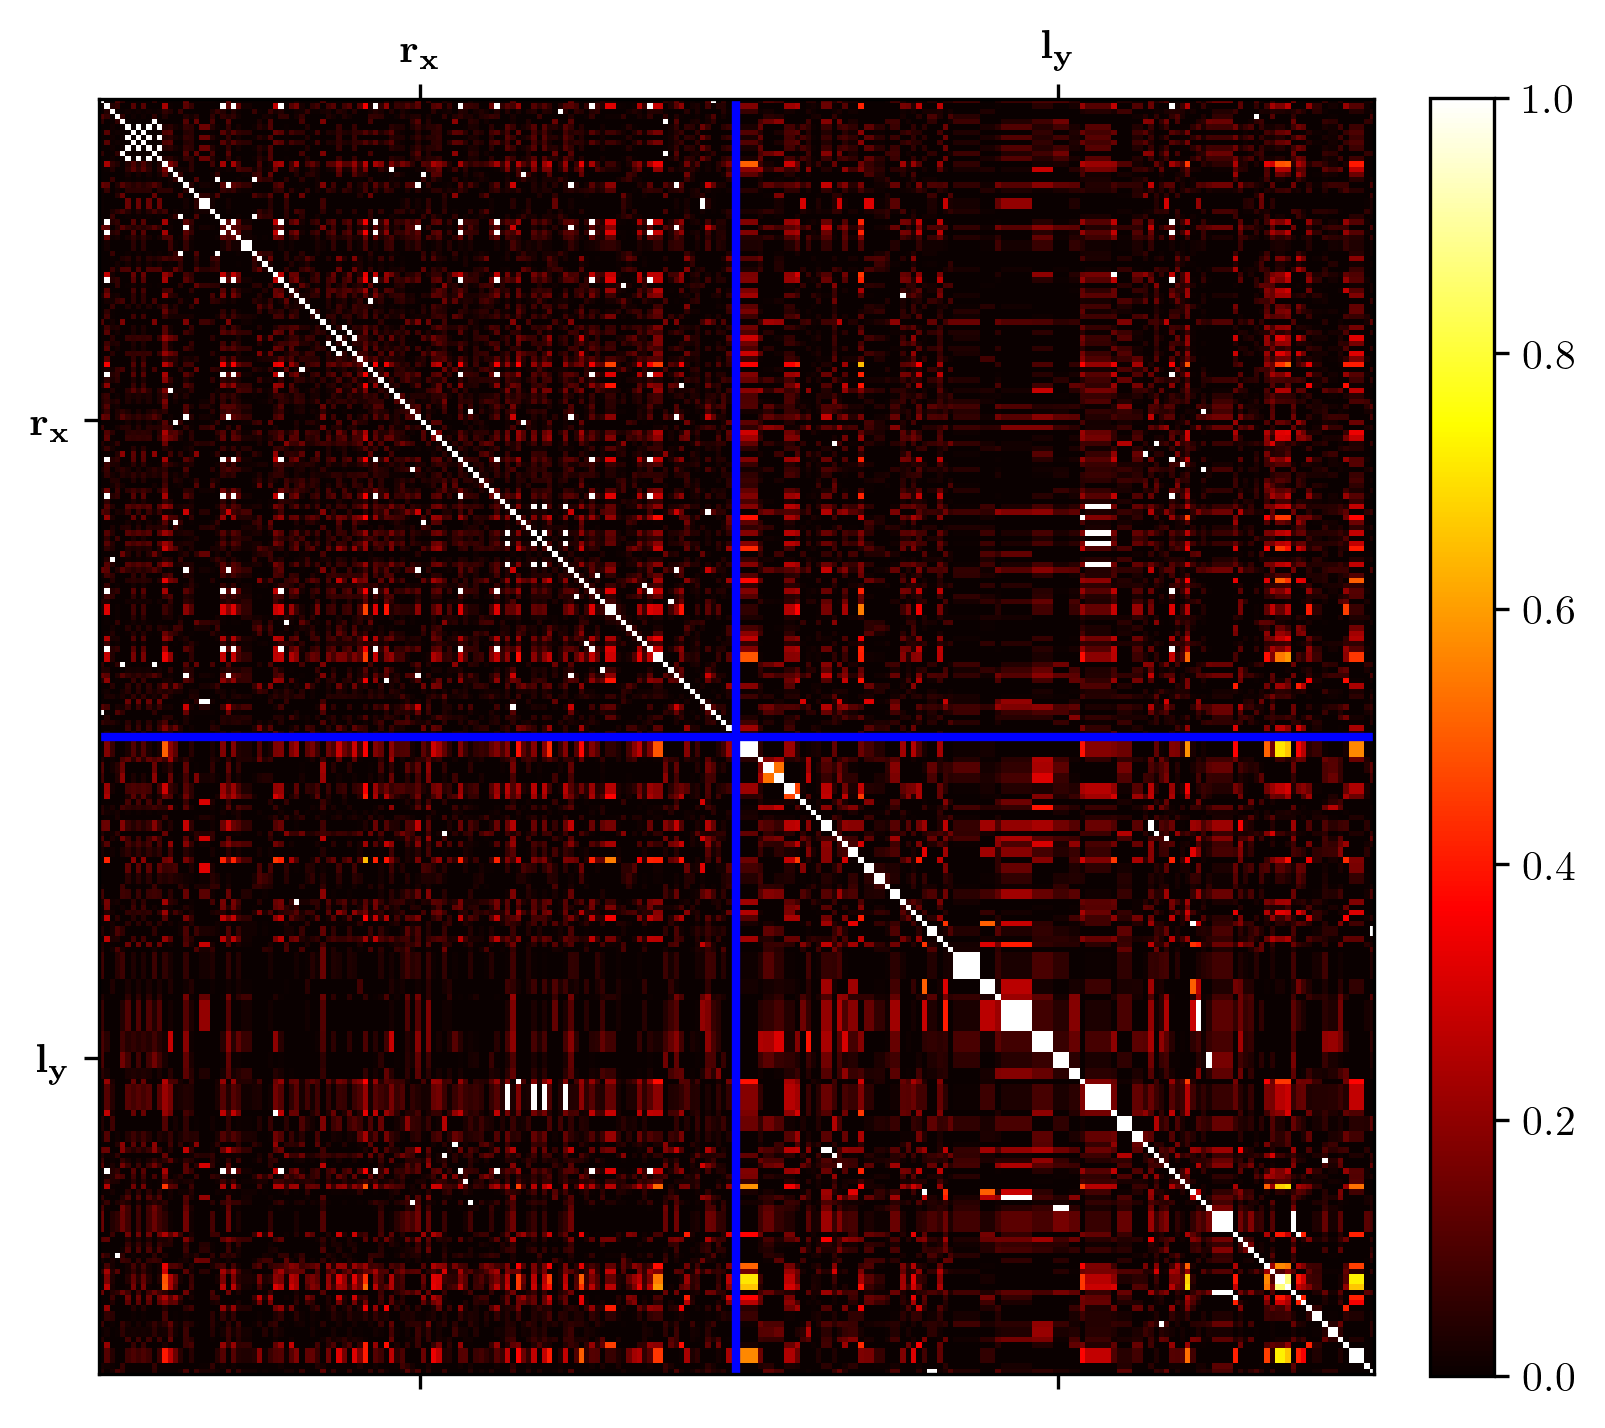

In [17]:
""" plot macrophage/monocyte graphs infividually """

metric = "correlation"

lrMarker = {
    'Monocytes' : expressedLigands,
    'Macrophages' : expressedReceptors,
}

clusterIds = {}

# get cell type specific indices
for ctype in ctypes: 
    mask = (cf['cellType'] == ctype) & (cf['key'] == key)
    t = cf[mask]['clusterId'].unique() 
    clusterIds[ctype] = t
    
    
""" get RNA data"""
data = rna[key]

rf = data.to_df()
print(f"{rf.shape=}")

# get the run key
allKeys = list(data.obs.keys() )
allKeys.remove('n_genes')
runKey = allKeys[0]

clusterInd = data.obs[runKey].astype(int) + 1   # note that these are zero-indexed!

# # get the cells and genes from the scRNA seq data
allmarkers = list(np.concatenate([lrMarker[x] for x in ctypes]).flat)
print(f"{len(allmarkers)=} {len(set(allmarkers))=}")
allInd = list(np.concatenate([clusterIds[x] for x in ctypes]).flat)
expressedMarkers = [x for x in allmarkers if x in rf.columns]
cellInd = clusterInd.isin(allInd)

# print the number of expressed genes
for i, ctype in enumerate(ctypes):
    cind = clusterIds[ctype]
    nCell = np.sum(clusterInd.isin(cind))
    nGene = len(lrMarker[ctype])
    print(f"{key} {ctype} n cells: {nCell} m genes: {nGene}")
    # # get the last index of expressed genes for axvline drawing    
    if i == 0:
        lastInd = nGene

# subset the expression matrix based on marker genes
cells = rf[cellInd]
cells = cells[expressedMarkers]
cells = cells.fillna(0)
print(f"{cells.shape=}")
    
dists = pdist(cells.T, metric)
D = squareform(dists) 
print(f"{D.shape=}")
D = 1 - D 
# D *= 1.0/D.max()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['figure.facecolor'] = "w"
plt.matshow(D, vmin=0, vmax=1, cmap="hot")

plt.colorbar(fraction=0.0458, pad=0.04)

plt.axvline(x=lastInd-0.5, c='b', lw=2)
plt.axhline(y=lastInd-0.5, c='b', lw=2)


l1 = (lastInd) / 2
l2 = ((len(expressedMarkers) - lastInd) / 2 ) + lastInd

# _ = plt.xticks([l1, l2], [ctypes[0] + " R", ctypes[1] + " L"])
_ = plt.xticks([l1, l2], [r"$\mathbf{r_x}$", r"$\mathbf{l_y}$"])
_ = plt.yticks([l1, l2], [r"$\mathbf{r_x}$", r"$\mathbf{l_y}$"])
# _ = plt.yticks([])
# plt.title(key)

len(markers['Monocytes'])=113
len(expressedLigands)=121
len(markers['Macrophages'])=76
len(expressedReceptors)=121
len(allmarkers)=431 len(set(allmarkers))=291
HFD8 Macrophages n cells: 2188 m genes: 197
HFD8 Monocytes n cells: 714 m genes: 234


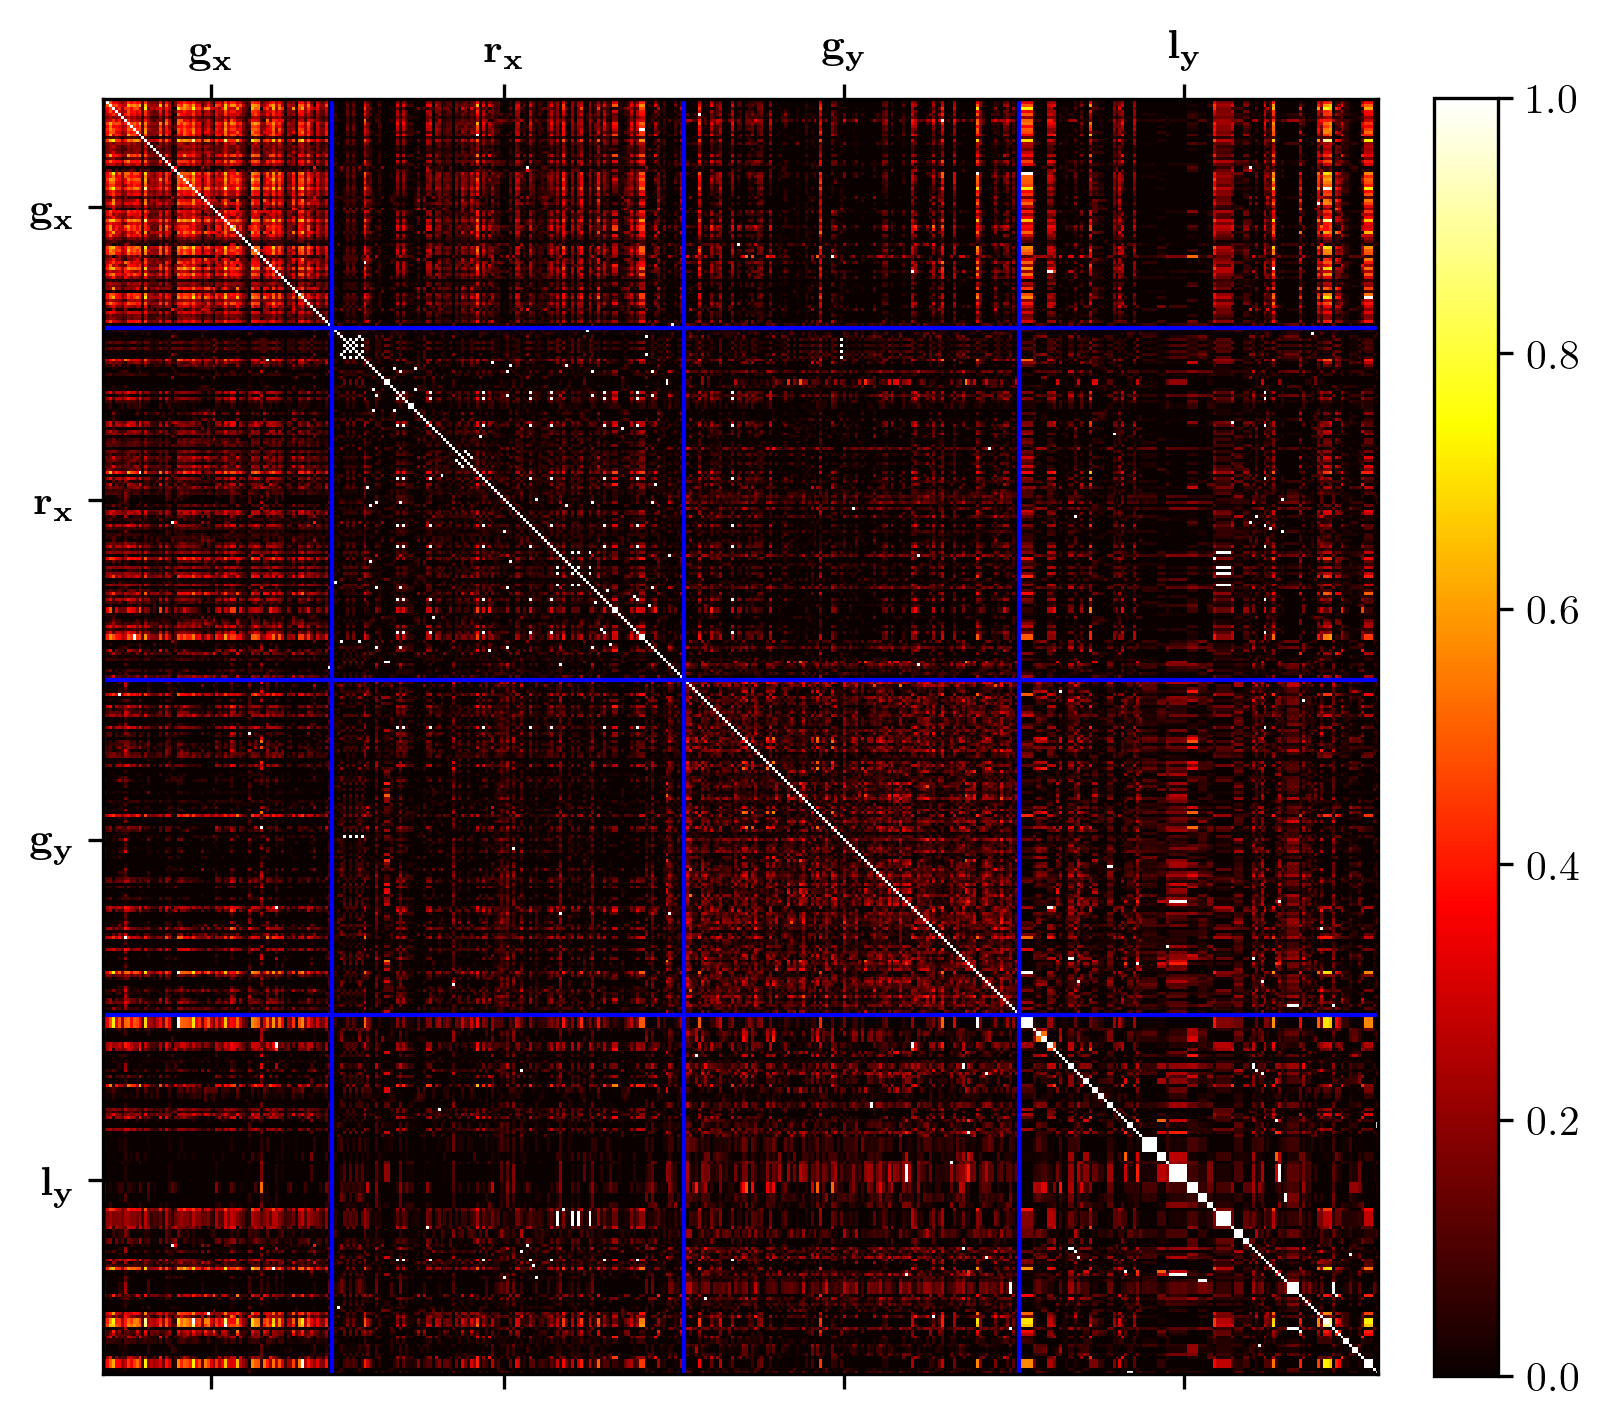

In [68]:
""" plot macrophage/monocyte graphs infividually """

metric = "correlation"

cmbMarker = {
    'Monocytes' : markers['Monocytes'] + expressedLigands,
    'Macrophages' : markers['Macrophages'] + expressedReceptors,
}


print(f"{len(markers['Monocytes'])=}")
print(f"{len(expressedLigands)=}")
print(f"{len(markers['Macrophages'])=}")
print(f"{len(expressedReceptors)=}")

    
    
""" get RNA data"""
data = rna[key]

rf = data.to_df()

# get the run key
allKeys = list(data.obs.keys() )
allKeys.remove('n_genes')
runKey = allKeys[0]

clusterInd = data.obs[runKey].astype(int) + 1   # note that these are zero-indexed!

# # get the cells and genes from the scRNA seq data
allmarkers = list(np.concatenate([cmbMarker[x] for x in ctypes]).flat)
print(f"{len(allmarkers)=} {len(set(allmarkers))=}")
allInd = list(np.concatenate([clusterIds[x] for x in ctypes]).flat)
expressedMarkers = [x for x in allmarkers if x in rf.columns]
cellInd = clusterInd.isin(allInd)

# print the number of expressed genes
for i, ctype in enumerate(ctypes):
    cind = clusterIds[ctype]
    nCell = np.sum(clusterInd.isin(cind))
    nGene = len(cmbMarker[ctype])
    print(f"{key} {ctype} n cells: {nCell} m genes: {nGene}")
    # # get the last index of expressed genes for axvline drawing    
    if i == 0:
        lastInd = nGene

# subset the expression matrix based on marker genes
cells = rf[cellInd]
cells = cells[expressedMarkers]
cells = cells.fillna(0)
    
dists = pdist(cells.T, metric)
D = squareform(dists) 
D = 1 - D
# D *= 1.0/D.max()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['figure.facecolor'] = "w"
plt.matshow(D, vmin=0, vmax=1, cmap='hot')

plt.colorbar(fraction=0.0458, pad=0.04)

xy = 77
plt.axvline(x=xy, c='b', lw=1)
plt.axhline(y=xy, c='b', lw=1)

xy = 196
plt.axvline(x=xy, c='b', lw=1)
plt.axhline(y=xy, c='b', lw=1)

xy = 309
plt.axvline(x=xy, c='b', lw=1)
plt.axhline(y=xy, c='b', lw=1)


locs = [36, 135, 250, 365]
labels = [r'$\mathbf{g_x}$', r"$\mathbf{r_x}$", r'$\mathbf{g_y}$', r"$\mathbf{l_y}$"]
_ = plt.xticks(locs, labels)
_ = plt.yticks(locs, labels)
# _ = plt.yticks([])
# plt.title(key)

In [19]:



# G = nx.from_numpy_matrix(D)
# nx.number_connected_components(G)

# L = csgraph.laplacian(D, normed=True)
# [w, v] = np.linalg.eigh(L)
# w[]

nx.is_connected(G)=True nx.number_connected_components(G)=1


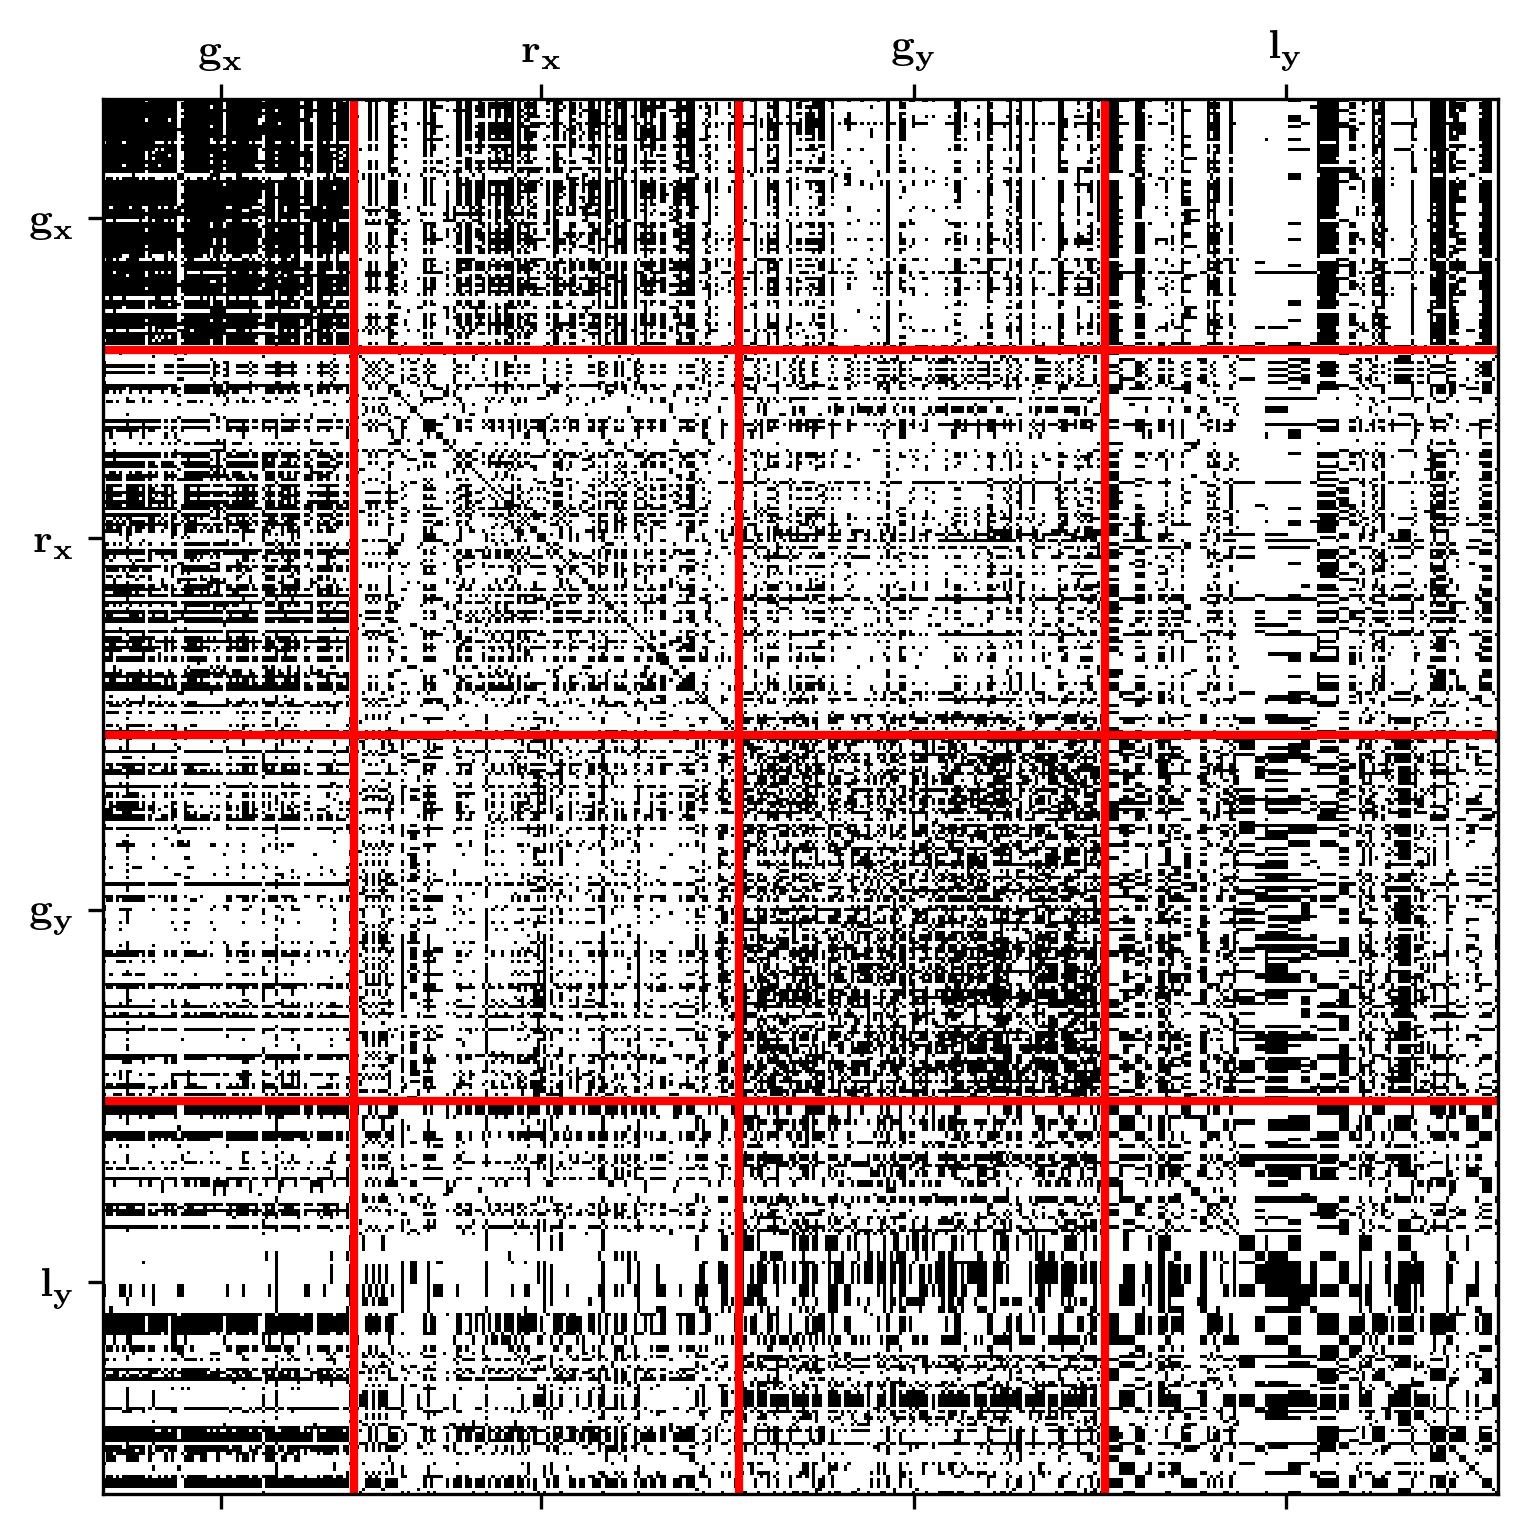

In [61]:
t = 0.06
linc = 'r'
lw = 2

Dhat = np.where(D > t, 1, 0)

G = nx.from_numpy_matrix(Dhat)
print(f"{nx.is_connected(G)=} {nx.number_connected_components(G)=}")

feat = nx.degree_centrality(G)

feat = pd.DataFrame.from_dict(feat, orient='index')
feat = feat.reset_index()
feat.columns = ['Node', 'Feature']

plt.matshow(Dhat, vmin=0, vmax=1, cmap='binary')

xy = 77
plt.axvline(x=xy, c=linc, lw=lw)
plt.axhline(y=xy, c=linc, lw=lw)

xy = 196
plt.axvline(x=xy, c=linc, lw=lw)
plt.axhline(y=xy, c=linc, lw=lw)

xy = 309
plt.axvline(x=xy, c=linc, lw=lw)
plt.axhline(y=xy, c=linc, lw=lw)

locs = [36, 135, 250, 365]
labels = [r'$\mathbf{g_x}$', r"$\mathbf{r_x}$", r'$\mathbf{g_y}$', r"$\mathbf{l_y}$"]
_ = plt.xticks(locs, labels)
_ = plt.yticks(locs, labels)


# """
# ADD NODE DEGREEE PLOT
# """
# ax = plt.gca()
# ax_divider = make_axes_locatable(ax)
# ax2 = ax_divider.append_axes("right", 
#                              size="15%", 
#                              pad="2%")

# ax2.barh(feat['Node'], 
#          feat['Feature'],
#          height=0.005,
#          color='k',
#          lw=0.85,
#          # alpha=0.4,
#          edgecolor='k',
#          zorder=2)

# ax2.sharey(ax)
# ax2.set_xticks([])
# ax2.set_xlabel('Degree')

In [21]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

1 0.2626066084791999
2 0.5966553750518259
3 0.6533176419526493


(0.0, 432.0)

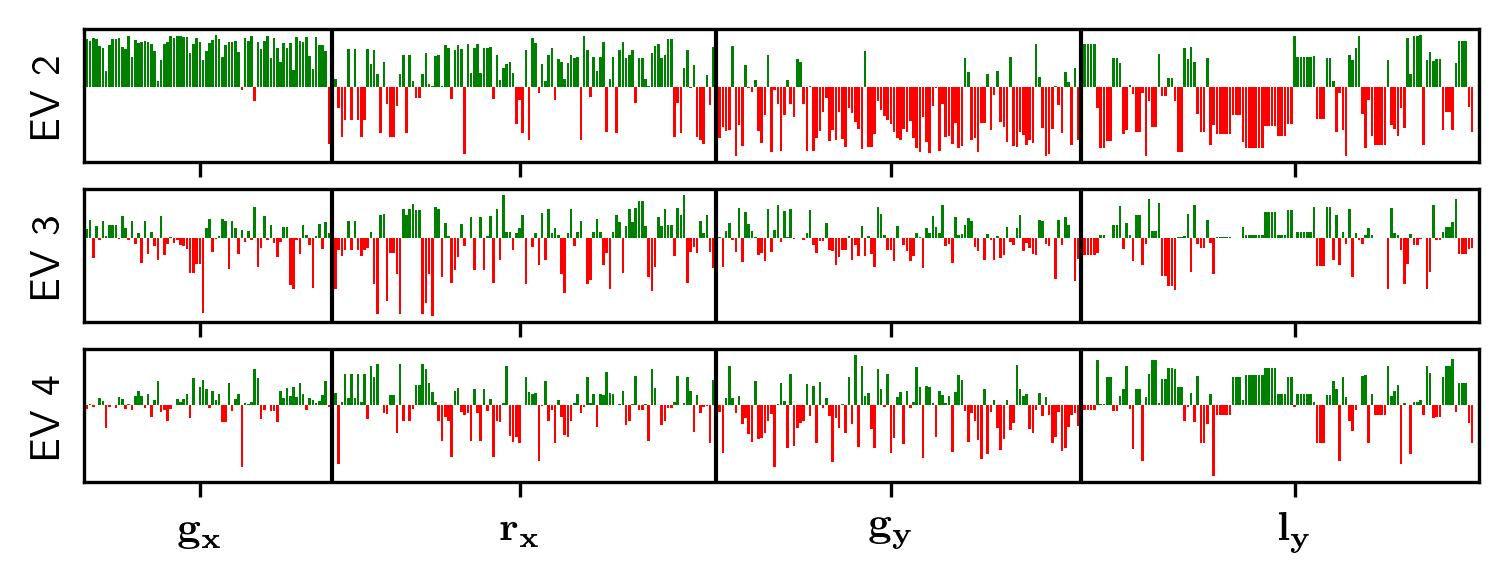

In [126]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 2
plt.rcParams['figure.facecolor'] = "w"

t = 0.06
lw=1
linc='k'

Dhat = np.where(D > t, 1, 0)
L = csgraph.laplacian(Dhat, normed=True)

val, vec = np.linalg.eigh(L)


fig, axs = plt.subplots(3, 1, sharex=True)
axs = axs.ravel()

for i in [1, 2, 3]:
    print(i, val[i])
    c = np.where(vec[:, i] > 0, 'g', 'r')
    axs[i-1].bar(range(len(val)), 
                 vec[:,i],
                 color=c)

    xy = 77
    axs[i-1].axvline(x=xy, c=linc, lw=lw)

    xy = 196
    axs[i-1].axvline(x=xy, c=linc, lw=lw)

    xy = 309
    axs[i-1].axvline(x=xy, c=linc, lw=lw)
    axs[i-1].set_yticks([])
    axs[i-1].set_ylabel(f"EV {i+1}")
    
    
locs = [36, 135, 250, 375]
labels = [r'$\mathbf{g_x}$', r"$\mathbf{r_x}$", r'$\mathbf{g_y}$', r"$\mathbf{l_y}$"]
_ = plt.xticks(locs, labels)
plt.xlim([0, Dhat.shape[0]+1])


# plt.colorbar()

$\mathbf{g_x}$ 0.8075357347064837
$\mathbf{r_x}$ 0.27798485247739574
$\mathbf{g_y}$ 0.6227072379236804
$\mathbf{l_y}$ 0.2654351591616265
nx.is_connected(G)=True nx.number_connected_components(G)=1
1.3827881283249241e-16


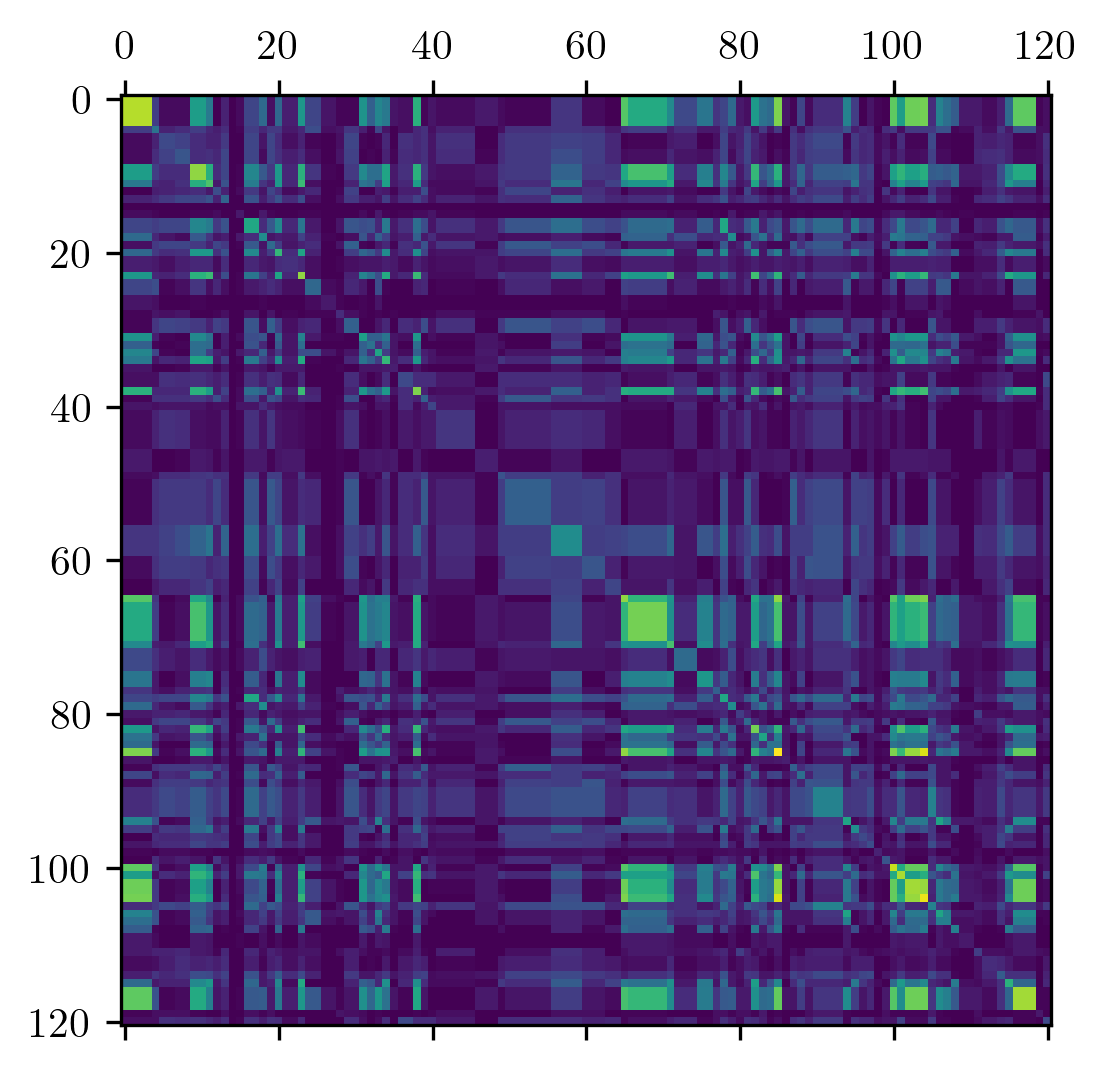

In [149]:
ranges = {
    r'$\mathbf{g_x}$' : [0, 76],
    r'$\mathbf{r_x}$' : [76, 76+121],
    r'$\mathbf{g_y}$' : [76+121, 76+121+113],
    r'$\mathbf{l_y}$' : [76+121+113, 76+121+113+121],
    
}

Dhat = np.where(D > t, 1, 0)

for label, sub in ranges.items():
    lb = sub[0]
    ub = sub[1]
    
    Dsub = Dhat[lb:ub, lb:ub]
    L = csgraph.laplacian(Dsub, normed=True)
    val, vec = np.linalg.eigh(L)
    
    print(label, val[1])
    

Dsub = Dhat[76:76+121, 76+121+113:76+121+113+121]
G = nx.from_numpy_matrix(Dsub)
print(f"{nx.is_connected(G)=} {nx.number_connected_components(G)=}")

Dsub = (Dsub.T @ Dsub) / 2
# Dsub = np.where(Dsub > 0, 1, 0)

plt.matshow(Dsub)

L = csgraph.laplacian(Dsub, normed=True)
val, vec = np.linalg.eigh(L)
print(val[1])


# plt.matshow(Dsub)

# L = csgraph.laplacian(Dhat, normed=True)


In [ ]:
len(markers['Monocytes'])=113
len(expressedLigands)=121
len(markers['Macrophages'])=76
len(expressedReceptors)=121

cells.shape=(2902, 13768)


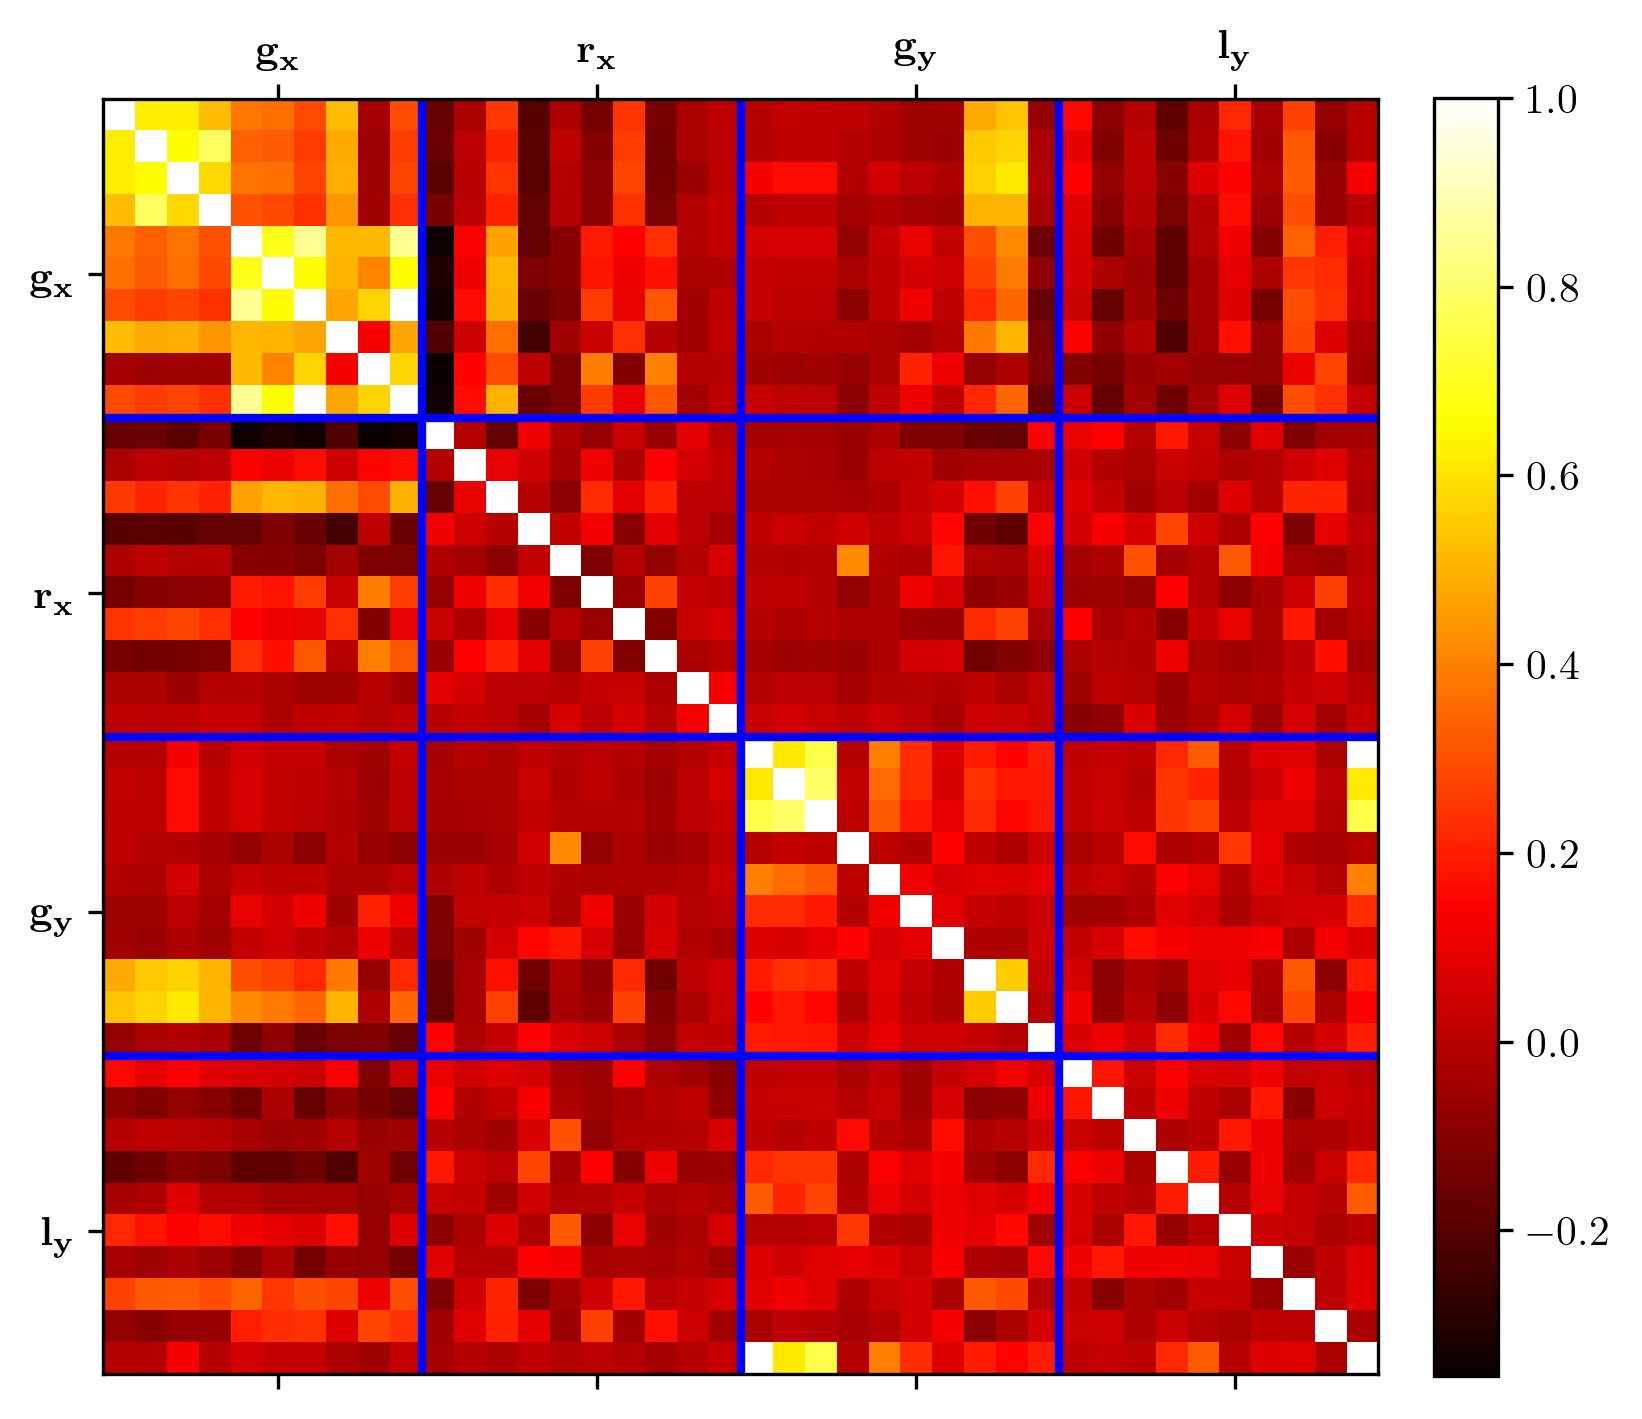

In [25]:
monoMark = ['SELP', 'LTBP1', 'PTGIS', 'G0S2', 'GATA6', 'FABP7', 'TNFAIP2', 'EDNRB', 'LTC4S', 'EMILIN2']
macroMark = ['CCL8', 'CD209F', 'C4B', 'CD209G', 'C1QC', 'APOE', 'C1QB', 'STAB1', 'TREM2', 'C1QB']

monoL = ['CCL2', 'CCL3','CSF1','FN1','IL6', 'MMP9', 'OSM','PROS1', 'SIRPA', 'SELP']
macroR = ['CCR2', 'CCR5','CSF1R','CD44','IL1R2','LRP1','LIFR','AXL', 'CD47', 'SELPLG']

genes =  macroMark + macroR + monoMark + monoL
n = len(genes)
A = np.zeros((n, n))

# subset the expression matrix based on marker genes
cells = rf[cellInd]
cells = cells.fillna(0)
print(f"{cells.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['figure.facecolor'] = "w"

for i, gi in enumerate(genes):
    for j, gj in enumerate(genes):
        xi = cells[gi].to_list()
        xj = cells[gj].to_list()
        r = pearsonr(xi, xj)[0]
        A[i, j] = r
        A[j, i] = r
        
        
plt.matshow(A, cmap='hot')
plt.colorbar(fraction=0.0458, pad=0.04)
        
xy = 9.5
plt.axvline(x=xy, c='b', lw=2)
plt.axhline(y=xy, c='b', lw=2)

xy = 19.5
plt.axvline(x=xy, c='b', lw=2)
plt.axhline(y=xy, c='b', lw=2)

xy = 29.5
plt.axvline(x=xy, c='b', lw=2)
plt.axhline(y=xy, c='b', lw=2)

locs = [5, 15, 25, 35]
labels = [r'$\mathbf{g_x}$', r"$\mathbf{r_x}$", r'$\mathbf{g_y}$', r"$\mathbf{l_y}$"]
_ = plt.xticks(locs, labels)
_ = plt.yticks(locs, labels)

In [ ]:
# t = lrPair[(~lrPair['ligand'].isin(monoMark)) & (~lrPair['ligand'].isin(macroMark))]
# t = t[(~t['receptor'].isin(monoMark)) & (~t['receptor'].isin(macroMark))]

# # t = t[t['Ligand.GO'] == 'Cytokine']

# print(t.shape)
# t[['ligand', 'receptor']].head(30)

In [ ]:
n = 20
key = "HFD8"
mask = (cf['key'] == key) & (cf['cellType'].isin(ctypes))

k = cf[mask].reset_index()
k['geneCount'] = k.groupby(['gene', 'cellType'])['clusterId'].transform('count')

k = k.sort_values(by=['geneCount', 'logfoldchanges'], ascending=[False, False])
mac = k[k['cellType'] == 'Macrophages']

print(mac['gene'].head(n).to_list())
print()
mono = k[k['cellType'] == 'Monocytes']
print(mono['gene'].head(n).to_list())
# k.head()


In [ ]:
print(set(markers['Monocytes']).intersection(expressedLigands))

print(set(markers['Macrophages']).intersection(expressedReceptors))

In [ ]:
75 + 148

In [ ]:
break

In [ ]:
"""get LR overlapping a cell type spot """



In [ ]:
# lft = 1
# alpha = 0.05
# keys = ['HFD14']
# ctypes = ['Macrophages', 'Monocytes']

# df = cf.copy()

# # simple filters
# df = df[df['cellType'].isin(ctypes)].reset_index(drop=True)
# df = df[df['key'].isin(keys)].reset_index(drop=True)

# df = df[df['logfoldchanges'] >= lft].reset_index(drop=True)
# df = df[df['pvals'] <= alpha].reset_index(drop=True)

# print(df.shape)

# # add the number of clusters
# df['nClusters'] = df.groupby('cellType')['clusterId'].transform('nunique')
# df['nGene'] = df.groupby(['cellType', 'gene'])['clusterId'].transform('nunique')

# # get genes in all clusters 
# df = df[df['nClusters']*.5 <= df['nGene']].reset_index(drop=True)


# print(df.shape)

# df = df.sort_values(by=['cellType', 'logfoldchanges'], ascending=[False, False])
# df['cellType'].value_counts()

In [ ]:
n = 10
print(df[df['cellType'] == 'Monocytes']['gene'].head(n).to_list())